# Метод статистической деконволюции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from random import random

In [2]:
from modules_reloader import reloader
from modules import randomized_ir, utils, plots, mcmc
relmod = reloader(randomized_ir, utils, plots, mcmc)

In [3]:
SAVE_IMAGES = False

## IR

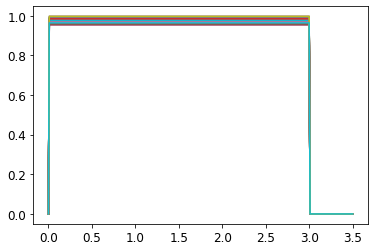

In [4]:
gamma = 0.5

pts_per_bin = 100
L_true = 3.5

ir_x = np.linspace(0, L_true, int(L_true * pts_per_bin))

# exp-decay
# ir_y = np.exp(- gamma * ir_x)

# step
step_width = 3
step_start = 0
ir_y = (np.logical_and(ir_x > step_start, ir_x <= step_start+step_width)).astype('float')

# gaussian shape
# x_max = 1
# x_sigma = 4
# ir_y = np.exp(- (ir_x - x_max) ** 2 / (2 * x_sigma ** 2))

factor_min, factor_max = 0.95, 1
rir = randomized_ir.RandomizedIr(ir_x, ir_y, factor=lambda: factor_min + random()*(factor_max - factor_min))
# rir = rir.RandomizedIr(ir_x, ir_y)

rir.plot_realizations(count=30)

# Convoluted signal

Pic: `\ref{pic:problem-setup}`


In [5]:
N = 50
n_vec_mean = 15

n_vec = utils.generate_poissonian_ns(n_vec_mean, N)

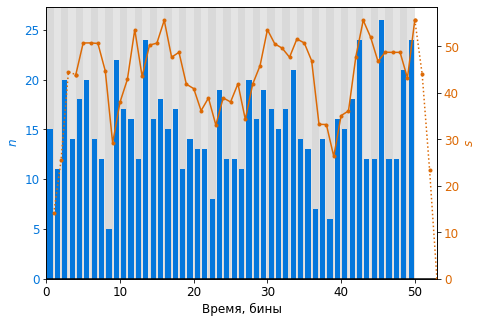

In [6]:
# uniform inbin time distribution:
s_vec = rir.convolve_with_n_vec(n_vec)

# non trivial inbin time distribution:
# S_vec = rir.convolve_with_n_vec(n_vec, inbin_invcdf=lambda x: x**(1/10), debug_inbin_times=True)

filename = 'problem-setup-example' if SAVE_IMAGES else None

f, a = plots.plot_convolution(n_vec, s_vec, filename=filename)

# Mean-based estimation

Chapter: `Грубая оценка методом наименьших квадратов`

In [7]:
rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=10000)

L = rireff.L

In [8]:
rireff.explore()

L=3 and N=50
RIR effects from photon in the bin #1 (t in [0; 1]):
t	effect
1	0.97 +/- 0.06
2	0.97 +/- 0.01
3	0.97 +/- 0.01
4	0.00 +/- 0.05

C matrix used to calculate mean-vector for a given n vector (with cut edge effects):
[[0.00412603 0.97468434 0.97483183 ... 0.         0.         0.        ]
 [0.         0.00412603 0.97468434 ... 0.         0.         0.        ]
 [0.         0.         0.00412603 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.96922095 0.         0.        ]
 [0.         0.         0.         ... 0.97483183 0.96922095 0.        ]
 [0.         0.         0.         ... 0.97468434 0.97483183 0.96922095]]

Xi matrix used to calculate covariance matrix for a given n vector:
[[ 2.31898291e-03  2.22406519e-04  2.08576467e-04  3.84554145e-03]
 [ 0.00000000e+00  1.03288993e-05  2.08581348e-04  1.97532488e-04]
 [ 0.00000000e+00  0.00000000e+00  9.72028628e-06  1.96709732e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.87917919

In [9]:
n_vec_estimation = rireff.estimate_n_vec(s_vec)

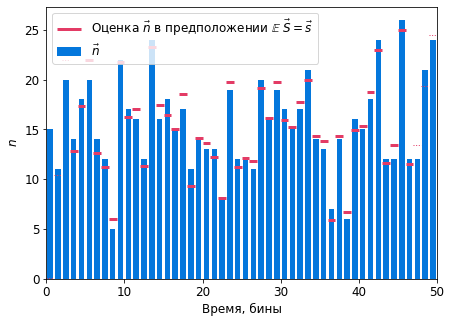

In [10]:
filename = 'mean-estimation' if SAVE_IMAGES else None
f, a = plots.plot_mean_n_estimation(n_vec, n_vec_estimation, L, filename=filename)


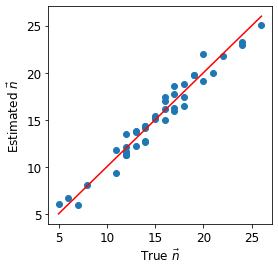

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))

cut_n_vec = n_vec[L:-L]
cut_n_vec_estimation = n_vec_estimation[L:-L]

ax.scatter(cut_n_vec, cut_n_vec_estimation)

n_minmax = np.linspace(cut_n_vec.min(), cut_n_vec.max(), 2)
ax.plot(n_minmax, n_minmax, 'r-')

ax.set_xlabel("True $\\vec{n}$")
ax.set_ylabel("Estimated $\\vec{n}$")

plt.show()

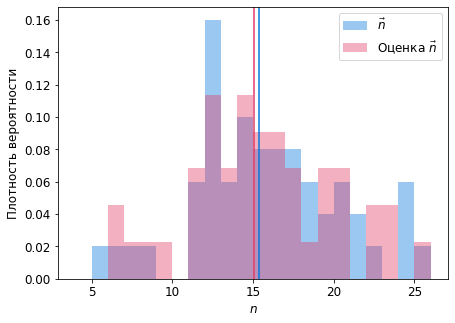

In [12]:
# filename = 'mean-estimation-assessment'
filename = None
f, a = plots.plot_mean_n_estimation_assessment(n_vec, n_vec_estimation, L, filename=filename)

# MCMC-based estimation

In [13]:
loglike = rireff.get_loglikelihood_mvn(s_vec)

loglike(n_vec_estimation)

19.53018443017656

In [14]:
n_min = np.zeros_like(n_vec)
n_max = n_vec * 100

def logposterior(n_vec):
    """Simple wrapper around loglike providing basic bounds for n_vec"""
    if np.any(np.logical_or(n_vec < n_min, n_vec > n_max)):
        return - np.inf
    return loglike(n_vec)

In [19]:
relmod()

In [20]:
N, tau, sample = mcmc.get_posterior_sample(logposterior, n_vec_estimation, L, True)

  1%|          | 10/1000 [00:17<29:33,  1.79s/it]/home/njvh/Documents/Science/sphere/thesis/thenv/lib/python3.8/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
0.3
100%|██████████| 1000/1000 [39:39<00:00,  2.38s/it]0.189



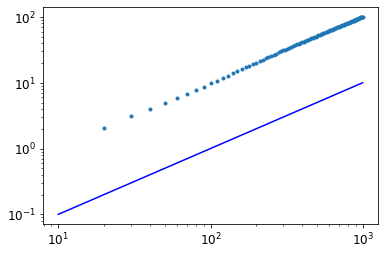

In [22]:
plt.plot(N, tau, '.')
plt.plot(N, np.array(N)/100, 'b-')
plt.xscale('log')
plt.yscale('log')

# OBSOLETE

In [19]:
# see https://emcee.readthedocs.io/en/stable/user/sampler/

import emcee

rng = np.random.default_rng()

n_walkers = 128

spread_from_estimation = 3  # from n_vec_estimation
n_starting_points = np.tile(n_vec_estimation, (n_walkers, 1)) + rng.normal(scale=spread_from_estimation, size=(n_walkers, N))

sampler = emcee.EnsembleSampler(n_walkers, N, logposterior)

In [20]:
sampler.run_mcmc(n_starting_points, 10000)
sample = sampler.get_chain(flat=True)

print('done!')

/home/njvh/Documents/Science/sphere/thesis/thenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
done!


# OK

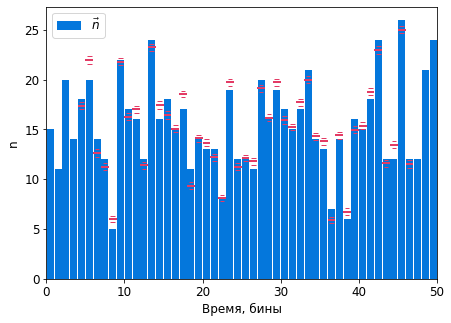

In [33]:
f, a = plots.plot_bayesian_mean_estimation(n_vec, sample, L)

Text(0.5, 0, 'n')

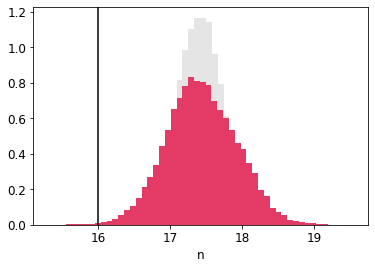

In [32]:
fig, ax =  plt.subplots()

burn_in = int(0.9 * sample.shape[0])
ibin = 14

ax.hist(sample[:burn_in, ibin], bins=50, density=True, color='black', alpha=0.1)
ax.hist(sample[burn_in:, ibin], bins=50, density=True, color='#e33b65')
ax.axvline(n_vec[ibin], color='black')

ax.set_xlabel('n')